In [79]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("/Users/evan/Documents/Projects/VsCode/Python/DSP"))
from DSP import transforms, domains, plotting, spectrum, windows

# Spectral Leakage and Windowing

## Causes of Spectral Leakage

By its very definition, the DFT,
$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j2\pi k\frac{n}{N}},\quad k \in \{0, 1,\ldots, N - 1\},
$$
presupposes that the $N$ -sampled signal $x[n]$ repeats forever. Recall, $x[n]$, though it not need be, is just the real part of a series of complex phasors of the form
$$
x[n] = \sum_k e^{j2\pi \frac{f_k}{f_s}n},\quad n \in \{0, 1,\ldots, N - 1\}.
$$
Therefore, periodicity is assumed prior to any sort of transformation. Moreover, because the DFT projects the signal along a strictly $N$ -periodic basis phasor, $x[n]$ must inherit the basis period $N$.

Of course, this is not a problem if the signal is itself guaranteed to be N-periodic. In general, such a condition is satisfied if 
$$
f_k = m\frac{f_s}{N}, \quad m \in \mathbb{Z}.
$$
That is, the signal frequency must be an integer multiple of the ratio of the sampling rate to the number of samples. However, failing to satisfy this condition results in unwanted behavior.

Consider the following two signals, each of which contain multiple-of-4 frequency components.

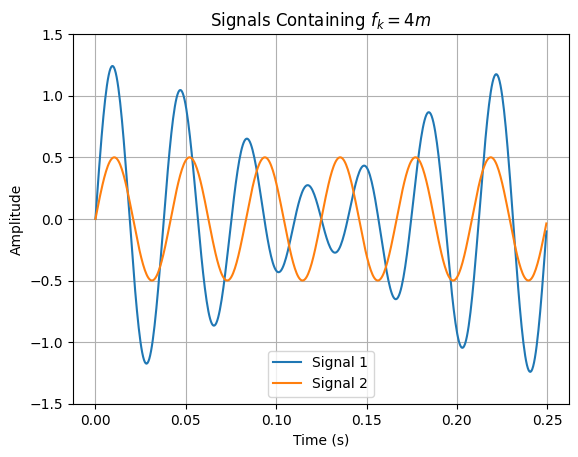

In [80]:
fs = 2048                   # Sampling rate                   
L = 512                     # Number of samples                       
tones1 = [24, 28]           # Frequencies in Hz
amps1 = [0.5, 0.75]         # Tone amplitudes
tones2 = [24]
amps2 = [0.5]
noise_coefficient = 0       # Gaussian noise scale

t = domains.times(fs, L)
s1 = domains.generate_signal(L, tones1, amps1, noise_coefficient, t)
s2 = domains.generate_signal(L, tones2, amps2, noise_coefficient, t)

fig, ax = plotting.plot_time([s1, s2], t, 'Signals Containing $f_k = 4m$', None, (None, (-1.5, 1.5)))
plt.show(ax)


Evidently, these two signals are periodic in $N$, meaning they can tile endlessly without any discontinuity at sample $N - 1$. If instead we tried to tile an $N$ -aperiodic signal, one whose frequency is not an integer multiple of $\frac{f_s}{N}$, then the following behavior occurs.

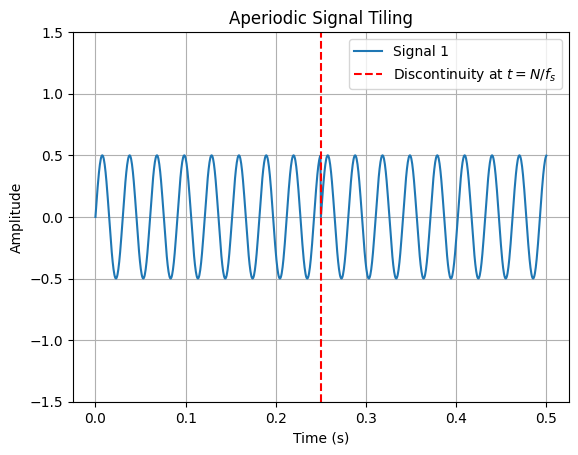

In [81]:
tones3 = [33]
s3 = domains.generate_signal(L, tones3, amps2, noise_coefficient, t)
s3_tiled = np.tile(s3, 2)
t_tiled = np.concatenate([t, np.linspace(L/fs, 2*L /fs, L, endpoint=True)])

fig, ax = plotting.plot_time(s3_tiled, t_tiled, 'Aperiodic Signal Tiling', None, (None, (-1.5, 1.5)))
ax.axvline(L/fs, color='r', linestyle='dashed', label='Discontinuity at $t = N/f_s$')
plt.legend()
plt.show(ax)

Notice the discontinuity at the tile boundary. 

What this ultimately means is that for a signal containing a misaligned frequency component, as the DFT compares it to the nearest aligned frequency, the signal's time-samples and the DFT's basis samples will never individually coincide. The effect of this is a smearing of the data into nearby bins.

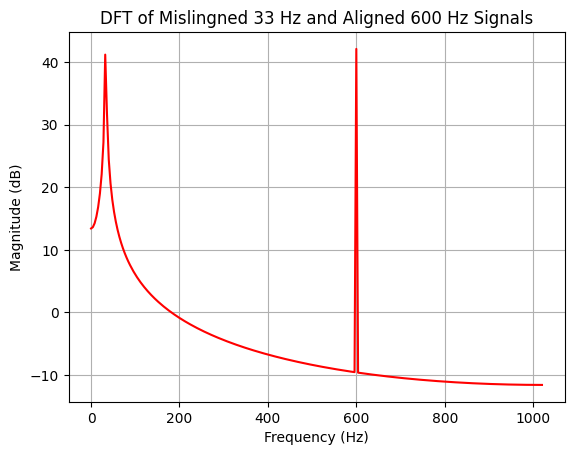

In [82]:
s4 = domains.generate_signal(L, [600], [0.5], 0, t)
s5 = [a + b for (a, b) in zip(s4, s3)]
fig, ax = plotting.plot_spectrum((s5, fs, L, 'fft', None), title='DFT of Mislingned 33 Hz and Aligned 600 Hz Signals', 
                                 labels=None, styles=[{'color': 'r'}])
plt.show(ax)

An ostensibly harmful consequence of this phenomenon is that any frequency data near enough to, and whose magnitude is small enough relative to, the main spike will become obscured by the swelling.

## Finite Sampling as an Effective Window

To understand the apparent broadening at the base of the frequency spike, we must first look to the notion of windowing and its affect on signal data in the time domain. Because we expect that any signal is a linear combination of several infinitely long periodic functions, the action of finitely sampling that signal is entirely analogous to truncating it between samples 0 and $N - 1$. One might liken such a process to viewing our signal through a "window" of size $N$.

In particular, finitely sampling an otherwise infinitely-long, periodic signal is identical to multiplying it, pointwise, by a length- $N$ step function. That is,
$$
x[n] = x_{\infty}[n] \cdot w_{\text{rect}}[n]
$$
where
$$
w_{\text{rect}}[n] = 
\begin{cases}
    1,& 0\leq n \leq N \\
    0,& \text{otherwise}
\end{cases}
$$
and $x_{\infty}[n]$ is the "true" periodic signal.

## The Dirichlet Kernel 

To cultivate some intuition for the effect that a particular multiplicative action has on a time domain signal in the frequency domain, it is common practice to first simply Fourier transform the action itself. Incidentally, out of this kind of analysis eventually comes a very important tool in signal processing that underpins a great deal of the later discussion on filters.

As promised, we will now attempt to apply the DFT to the rectangular window itself, $w_{\text{rect}}[n]$. By definition,
$$
W_{\text{rect}}[k] = \sum_{n = -\infty}^{\infty} w_{\text{rect}}[n]e^{-j2\pi k\frac{n}{N}} = \sum_{n = 0}^{N - 1}e^{-j2\pi k\frac{n}{N}}.
$$
This is simply a geometric series with ratio $e^{-j2\pi  \frac{k}{N}}$, so
$$
W_{\text{rect}}[k] = \frac{1-e^{-j2\pi k}}{1 - e^{-j2\pi  \frac{k}{N}}}.
$$
Now, we can center the phase by multiplying the numerator and denominator by $e^{j\pi k}$ and $e^{j\pi  \frac{k}{N}}$ respectively. It follows that 
$$
W_{\text{rect}}[k] = \frac{e^{j\pi \frac{k}{N}}}{e^{j\pi k}}\frac{e^{j\pi k}-e^{-j\pi k}}{e^{j\pi \frac{k}{N}} - e^{-j\pi  \frac{k}{N}}} = e^{-j\pi\frac{N-1}{N}k}\frac{\sin(\pi k)}{\sin(\pi k /N)}.
$$
Up to a linear phase term, the magnitude of the rectangular window's frequency response is
$$
\left|W_{\text{rect}}[k]\right| = D_N(k) = \left|\frac{\sin(\pi k)}{\sin(\pi k /N)}\right|,
$$
otherwise known as the Dirichlet kernel. 

If, instead, we first multiplied our signal $x_{\infty}$, which we can for now suppose is just a pure tone at bin $k_0$, by the window, we would simply arrive at the same Dirichlet kernel, except offset by the tone's bin index $k_0$. Specifically, 
$$
\left|W_{\text{windowed}}[k]\right| = D_N(k - k_0) = \left|\frac{\sin(\pi (k -k_0))}{\sin(\pi (k - k_0) /N)}\right|.
$$

**Note:** *This most recent discussion about shifting the location of the kernel deliberately omits a justification for the given result. Instead, due to its importance in later sections, the ideas ignored here will receive their own investigation. Suffice it to accept this result as true.*

The following is a direct plot of the Dirichlet kernel.

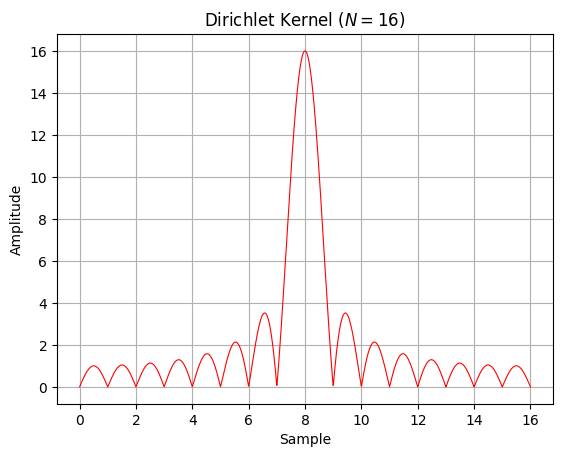

In [83]:
N = 16
k_0 = 8

ks = np.linspace(0, N, 1600)
delta = ks - k_0

kernel = np.abs(np.sin(np.pi * delta) / np.sin(np.pi * delta / N))
plt.plot(ks, kernel, color='r', linewidth='0.8', label='Continuous Dirichlet Kernel')
plt.title("Dirichlet Kernel ($N = 16$)")
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

Take note of the following features of this function:
- Zeros reside at $k \in \mathbb{Z} \backslash \{0\}$.
- The main lobe has a 2-bin width, while the sidelobes are each 1 bin wide. i.e. $4\pi/N$ rad/sample.

Now, consider the following 16-sample rectangular window response centered on an integer bin. Note that the underlying Dirichlet kernel represents a continuum of the possible spectral bins, where only those that lie on the genuine sample grid are evaluated. This is a magnitude plot in the frequency domain.

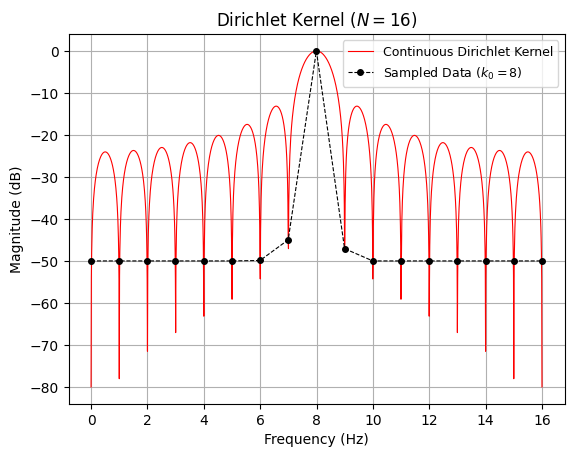

In [84]:
N = 16
k_0 = 8
floor_db = -80

ks = np.linspace(0, N, 1600)
delta = ks - k_0

kernel_mag = np.abs(np.sin(np.pi * delta) / np.sin(np.pi * delta / N))
mag_norm = kernel_mag / np.max(kernel_mag)
mag_norm = np.maximum(mag_norm, 10**(floor_db/20))
kernel_db = 20*np.log10(mag_norm)

idx = (np.arange(N+1)*(len(ks) - 1) // N).astype(int)
ks_discrete = ks[idx]
kernel_discrete = kernel_db[idx]
kernel_discrete = np.maximum(kernel_discrete, -50)

plt.plot(ks, kernel_db, color='r', linewidth='0.8', label='Continuous Dirichlet Kernel')
plt.plot(ks_discrete, kernel_discrete, color='black', linewidth='0.8', 
         linestyle='dashed', marker='o', markersize='4', label='Sampled Data ($k_0=8$)')
plt.title('Dirichlet Kernel $(N = 16)$')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend(fontsize=9)
plt.show()

Observe that an $\frac{f_s}{N}$ divisible signal frequency, one whose frequency bin index
$$
k_0 = \frac{f_k N}{f_s} = m
$$
is an integer, permits samples that lie only along the principal zeros and the main peak of the window kernel. This is the usual kind of behavior we see in spectral peaks, where all of the signal energy is confined to the main lobe. Moreover, while this representation limits the noise floor to -50 dB, the actual zero or root bins will lie as low as the kernel manages to get. This just means that we can be especially certain that all the signal energy resides in the main peak and doesn't hide in some deeply attenuated side lobe.


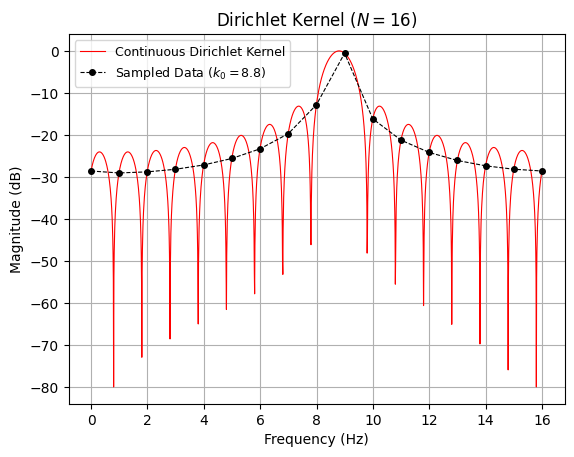

In [85]:
N = 16
k_0 = 8.8
floor_db = -80

ks = np.linspace(0, N, 1600)
delta = ks - k_0

kernel_mag = np.abs(np.sin(np.pi * delta) / np.sin(np.pi * delta / N))
mag_norm = kernel_mag / np.max(kernel_mag)
mag_norm = np.maximum(mag_norm, 10**(floor_db/20))
kernel_db = 20*np.log10(mag_norm)

idx = (np.arange(N+1)*(len(ks) - 1) // N).astype(int)
ks_discrete = ks[idx]
kernel_discrete = kernel_db[idx]

plt.plot(ks, kernel_db, color='r', linewidth='0.8', label='Continuous Dirichlet Kernel')
plt.plot(ks_discrete, kernel_discrete, color='black', linewidth='0.8', 
         linestyle='dashed', marker='o', markersize='4', label='Sampled Data ($k_0=8.8$)')
plt.title('Dirichlet Kernel $(N = 16)$')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend(fontsize=9)
plt.show()

However, when that bin index $k_0$ is not an integer, meaning the signal frequency does not evenly divide $\frac{f_s}{N}$, the kernel becomes offset from the frequency grid, forcing bin samples outside the main lobe to borrow energy. What's more, the main spike actually suffers a loss in magnitude itself as a result. This, of course, should not be a surprise given that the energy of any system ought to be conserved.

Notice the characteristic decay of the envelope, resembling that of the leaky 33 Hz tone's silhouette shown in the earlier example.


## Methods of Managing Spectral Leakage 

In practice, finite-sampling, specifically aperiodic sampling, is effectively a guarantee in signal analysis, barring uniquely advanced techniques. As signals become more complicated and therefore more realistic, it becomes more and more difficult to sample them uniformly. In fact, it is often the case that sampling procedures are, in and of themselves, discrete, making each packet of samples even harder to reconcile with a transform.

As we've seen, spectral leakage presents the following consequences:
- Raised noise floor near strong tones. This can mask off weak, nearby signal data.
- Amplitude underestimation for off-bin tones.
- Bias in distortion metrics.

That being said, because we *can* control the sample length, and by extension the window size, an obvious suggestion may be to modify the kind of window we "look" through. Specifically, because the aperiodic signal must pick up energy according to the window's frequency response shape, if that shape were modified slightly, we could comparably modify the nature of the energy distribution. Then, all it takes is to multiply the sampled signal by the modified window rather than a rectangular one.

A tuned window will often compromise clarity in one regime for uncertainty in another. For instance, some windows favor main lobe width over side lobe attenuation. 

### Hann Window

Let's consider a common raised-cosine window called the Hann window. They are called raised-cosine because they have the form:
$$
w[n] = a_0 - (1 - a_0)\cdot \cos\left(\frac{2\pi n}{N}\right),\quad 0 \leq n \leq N.
$$
Choosing $a_0 = 0.5$ produces a Hann window. Thus,
$$
w_{\text{Hann}}[n] = 0.5\left[1 - \cos\left(\frac{2\pi n}{N}\right)\right] = \sin^2\left(\frac{\pi n}{N}\right).
$$

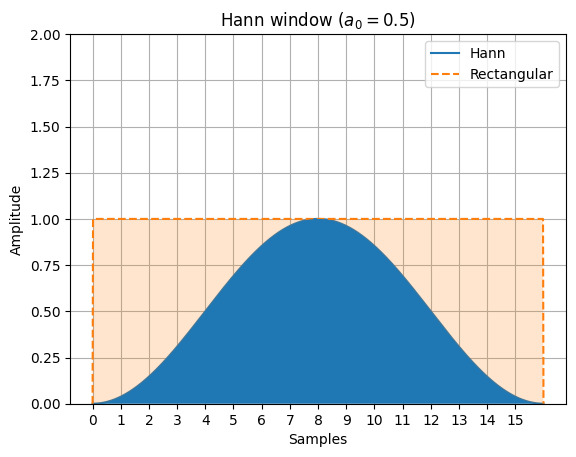

In [86]:
N = 16
n = np.linspace(0, N, 1000)


w_hann = 0.5 - 0.5*np.cos(2*np.pi * n / N)
w_rect = np.full(len(n), 1)
w_rect[0], w_rect[999] = 0, 0
plt.plot(n, w_hann, label='Hann')
plt.plot(n, w_rect, linestyle='dashed', label='Rectangular')
plt.title('Hann window ($a_0 =0.5$)')
plt.xticks(np.arange(16))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.ylim(0, 2)

plt.fill_between(n, w_hann, zorder=3)
plt.fill_between(n, w_rect, zorder=2, alpha=0.2)
plt.grid(zorder=0)
plt.legend()
plt.show()

Take particular note of the deliberate tapering of the window down to the cutoff points. The frequency response of this window is as follows.

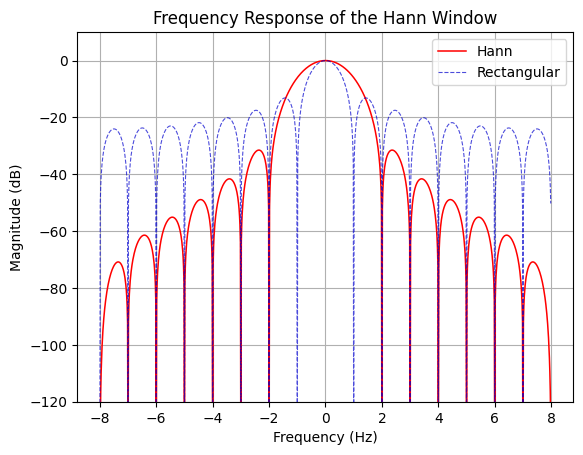

In [87]:
N = 16
ZP  = 64*N 
a_0 = 0.5

# Hann fft
w_hann_discrete = windows.raised_cosine(a_0, N)
w_hann_discrete = np.pad(w_hann_discrete, (0, ZP - N))

W_hann = transforms.radix2_fft(w_hann_discrete, ZP)
W_hann = np.abs(W_hann)
W_hann = transforms.fftshift(W_hann)
W_hann /= W_hann.max() if W_hann.max() > 0 else 1.0
W_hann = np.maximum(W_hann, 10**(-150/20))
W_hann = 20*np.log10(W_hann)

# Rectangular fft
w_rect_compare = np.full(N, 1)
W_rect = transforms.radix2_fft(w_rect_compare, ZP)
W_rect = np.abs(W_rect)
W_rect = transforms.fftshift(W_rect)
W_rect /= W_rect.max() if W_rect.max() > 0 else 1.0
W_rect = np.maximum(W_rect, 10**(-150/20))
W_rect = 20*np.log10(W_rect)

f = np.linspace(-8, 8, ZP, endpoint=False)

plt.plot(f, W_hann, color='r', linewidth='1.1', label='Hann')
plt.plot(f, W_rect, color='mediumblue', linestyle='dashed', linewidth='0.8', alpha=0.7, label='Rectangular')
plt.ylim(-120, 10)
plt.title('Frequency Response of the Hann Window')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.show()

The two most striking features of the Hann window are the mainlobe width and sidelobe attenuation. Notice that the Hann window has a first sidelobe suppression of ~-31 dB. The sidelobes continue to fall off significantly. However, this benefit comes at the cost of widening the mainlobe to twice the width of the rectangular window's.

The Hann window serves as a solid, general-purpose window that helps to reduce noise floor swelling around high-magnitude spectral peaks. It's overall behavior is very typical of the set of standard windows, where the differences among them arise as a tradeoff between mainlobe width and sidelobe attenuation.

It is once again important to note that the above plot is a strongly padded transform of the original window. This is done to greatly increase the number of actual frequency samples in the spectrum so as to accentuate the lobe profile of the window. The true bins are evaluated where the window response intersects the genuine sample grid.

Now, consider, again, the off-tone signal we constructed previously. Let's apply the Hann window prior to taking its Fourier transform.

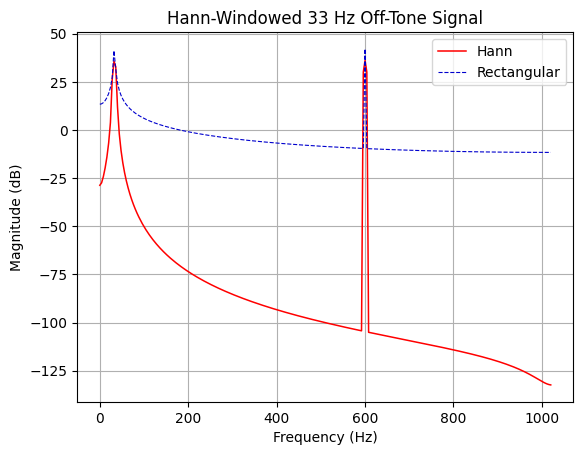

In [88]:
s5_hann = s5*windows.raised_cosine(0.5, len(s5))

fig2, ax2 = plotting.plot_spectrum((s5_hann, fs, L, 'fft', None), (s5, fs, L, 'fft', None), title='Hann-Windowed 33 Hz Off-Tone Signal', labels=['Hann', 'Rectangular'],
                                   styles=[{'color': 'red', 'linewidth': '1.1'}, {'color': 'mediumblue', 'linewidth': '0.8', 'linestyle': 'dashed'}])

Evidently, the previously leaky off-tone signal now presents with a far deeper attenuation at the base of the spike, thus recapturing some of that lost energy. This effect makes identifying the tone far more trivial, especially if the signal were busier. Additionally, notice that the 600 Hz tone was left nearly unaffected by the window. Nonetheless, if it were much closer to a leaky tone, its base may begin to widen as it impinges on extraneous lobes.

Further, even though it is difficult to see, the main spike becomes wider at the very tip after applying the Hann window, as expected. However, this effect is almost negligible in certain cases such as this, demonstrating the utility of these windowing methods. Ultimately, in exchange for some minor mainlobe widening and a slight maximum peak attenuation, the relevant signals become significantly more apparent, an important consideration in comparative analysis.

Still, we can account for windowing loss simply by considering the coherent gain. Coherent gain, defined as
$$
CG = \frac{1}{N}\sum_{n=0}^{N-1}w[n],
$$
is simply the average value of the time-domain window. Evidently, the rectangular window has unity coherent gain, so we see no loss overall. However, the Hann window, being a simple cosine, has a coherent gain of $0.5$. Hence, we lose exactly $20 \log_{10}(0.5) = 6.02$ dB as a consequence of tapering the signal data. By simply dividing the spectral data, prior to logarithmic scaling, by the coherent gain, we can recover the proper amplitude information with respect to unity (rectangular) truncation.

Let us now consider some additional windows and their advantages and disadvantages.

### Hamming Window

The Hamming window is yet another raised cosine window. In this case, $a_0 \approx 0.538$. It has the form
$$
w_{\text{Hamming}}[n] = 0.538 - (1 - 0.538) \cdot\cos\left(\frac{2\pi n}{N}\right).
$$

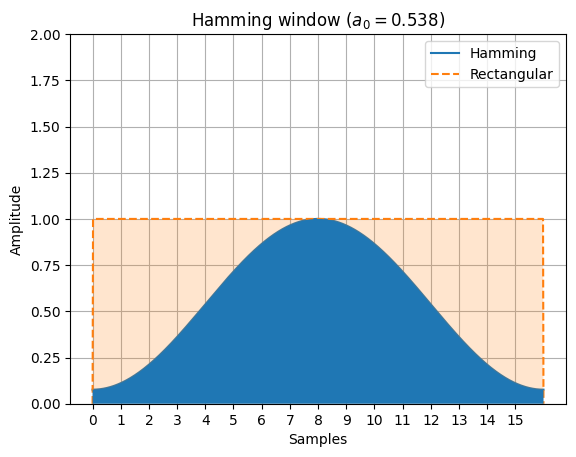

In [89]:
N = 16
n = np.linspace(0, N, 1000)
a_0 = 0.538

w_hann = a_0-(1-a_0)*np.cos(2*np.pi * n / N)
w_rect = np.full(len(n), 1)
w_rect[0], w_rect[999] = 0, 0
plt.plot(n, w_hann, label='Hamming')
plt.plot(n, w_rect, linestyle='dashed', label='Rectangular')
plt.title('Hamming window ($a_0 = 0.538$)')
plt.xticks(np.arange(16))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.ylim(0, 2)

plt.fill_between(n, w_hann, zorder=3)
plt.fill_between(n, w_rect, zorder=2, alpha=0.2)
plt.grid(zorder=0)
plt.legend()
plt.show()

Indeed, this window looks just like a cosine peak sitting atop a half-period pedestal. The frequency response for this window is as follows.

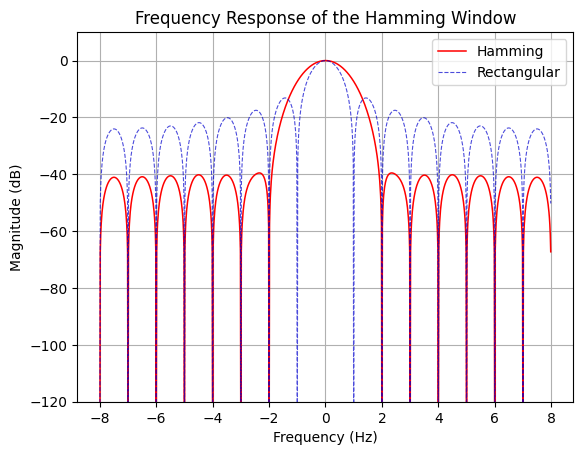

In [90]:
N = 16
ZP  = 64*N 
a_0 = 0.538

# Hamming fft
w_hamming_discrete = windows.raised_cosine(a_0, N)
w_hamming_discrete = np.pad(w_hamming_discrete, (0, ZP - N))

W_hamming = transforms.radix2_fft(w_hamming_discrete, ZP)
W_hamming = np.abs(W_hamming)
W_hamming = transforms.fftshift(W_hamming)
W_hamming /= W_hamming.max() if W_hamming.max() > 0 else 1.0
W_hamming = np.maximum(W_hamming, 10**(-150/20))
W_hamming = 20*np.log10(W_hamming)

f = np.linspace(-8, 8, ZP, endpoint=False)

plt.plot(f, W_hamming, color='r', linewidth='1.1', label='Hamming')
plt.plot(f, W_rect, color='mediumblue', linestyle='dashed', linewidth='0.8', alpha=0.7, label='Rectangular')
plt.ylim(-120, 10)
plt.title('Frequency Response of the Hamming Window')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.show()

The Hamming window is predictably similar in nature to the Hann window. Again, the mainlobe width is double that of the rectangular response. However, the first sidelobe gets suppressed to roughly -40 dB and the remaining sidelobes barely suppress any further. We expect to see a high, albeit relatively flat, noise floor, with the advantage of a narrower and deeper spike base.

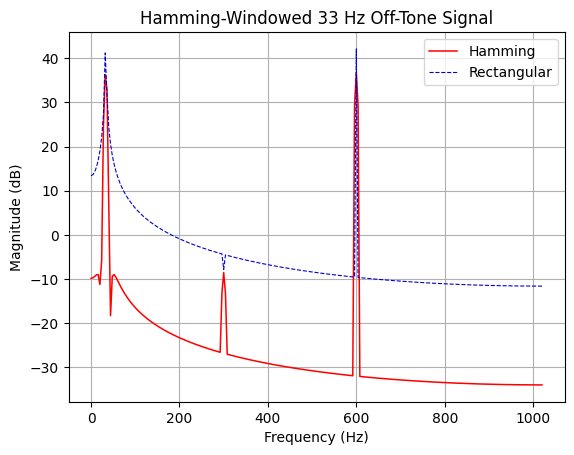

In [91]:
s6 = domains.generate_signal(L, [300], [0.003], 0, t)
s7 = [a + b for (a, b) in zip(s5, s6)] 
s7_hamming = s7*windows.raised_cosine(0.538, len(s7))

fig3, ax3 = plotting.plot_spectrum((s7_hamming, fs, L, 'fft', None), (s7, fs, L, 'fft', None), title='Hamming-Windowed 33 Hz Off-Tone Signal', labels=['Hamming', 'Rectangular'],
                                   styles=[{'color': 'red', 'linewidth': '1.1'}, {'color': 'mediumblue', 'linewidth': '0.8', 'linestyle': 'dashed'}])

Indeed, our noise floor has come up a good amount, shadowing the raw noise floor linearly. On the other hand, the leaky tone's spike is especially narrow, all the way down to the new floor. Moreover, with the addition of another pure tone in the spectrum, where the rectangular window indicates only an unreliable blip, the Hamming window clearly identifies it at 300 Hz. Of course, under the obstruction of noise, a practical guarantee, this blip in the raw spectrum could go completely unnoticed.

The Hamming window has a coherent gain of ~ 0.54.

# Blackman Window

The Blackman window is similar to the previous two in construction. It may be represented as a cosine series of the form
$$
w_{\text{Blackman}}[n] = a_0-a_1\cos\left(\frac{2\pi n}{N}\right)+a_2\cos\left(\frac{4\pi n}{N}\right),\quad a_0 = \frac{1- \alpha}{2};\quad a_1 = \frac{1}{2};\quad a_2 = \frac{\alpha}{2}.
$$
The most conventional choice for $\alpha$ is 0.16.

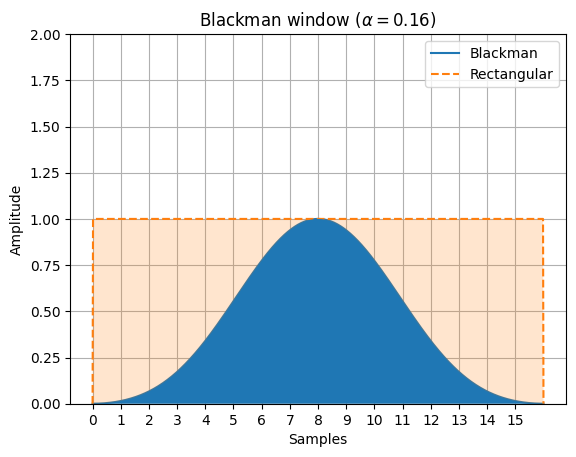

In [92]:
N = 16
n = np.linspace(0, N, 1000)
alpha1 = 0.16

a_0 = (1-alpha1) / 2
a_1 = 0.5
a_2 = alpha1 / 2

w_blackman = a_0-a_1*np.cos(2*np.pi*n/N)+a_2*np.cos(4*np.pi*n/N)
plt.plot(n, w_blackman, label='Blackman')
plt.plot(n, w_rect, linestyle='dashed', label='Rectangular')
plt.title(r'Blackman window ($\alpha = 0.16$)')
plt.xticks(np.arange(16))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.ylim(0, 2)

plt.fill_between(n, w_blackman, zorder=3)
plt.fill_between(n, w_rect, zorder=2, alpha=0.2)
plt.grid(zorder=0)
plt.legend()
plt.show()

Once again, we see a very similar structure to the Hann window. However, the Blackman window tapers off slightly more aggressively. The frequency response for this window is as follows.

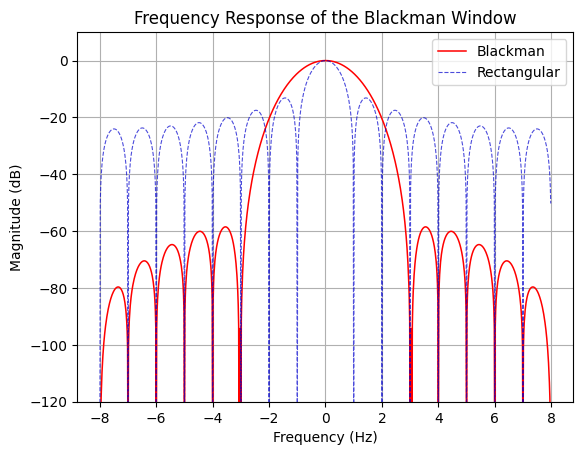

In [93]:
N = 16
ZP  = 64*N
n = np.arange(N)

# Blackman fft
w_blackman_discrete = a_0-a_1*np.cos(2*np.pi*n/(N))+a_2*np.cos(4*np.pi*n/(N))
w_blackman_discrete = np.pad(w_blackman_discrete, (0, ZP-N))

W_blackman = transforms.radix2_fft(w_blackman_discrete, ZP)
W_blackman = np.abs(W_blackman)
W_blackman = transforms.fftshift(W_blackman)
W_blackman /= W_blackman.max() if W_blackman.max() > 0 else 1.0
W_blackman = np.maximum(W_blackman, 10**(-150/20))
W_blackman = 20*np.log10(W_blackman)

f = np.linspace(-8, 8, ZP, endpoint=False)

plt.plot(f, W_blackman, color='r', linewidth='1.1', label='Blackman')
plt.plot(f, W_rect, color='mediumblue', linestyle='dashed', linewidth='0.8', alpha=0.7, label='Rectangular')
plt.ylim(-120, 10)
plt.title('Frequency Response of the Blackman Window')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.show()

Not unlike the previous two cosine-type windows, the Blackman window has a wide mainlobe and single-bin sidelobes. In this instance, the mainlobe is triple the width of the rectangular window's, meanwhile the first sidelobe is suppressed by an extraordinary ~-60 dB. The remaining sidelobes fall off at an increasing scale, though not quite as aggressively as that of the Hann window.

Indeed, we again should suspect a off-tone spike whose tip is slightly widened, but whose base is overall very narrow down to a considerable attenuation depth.

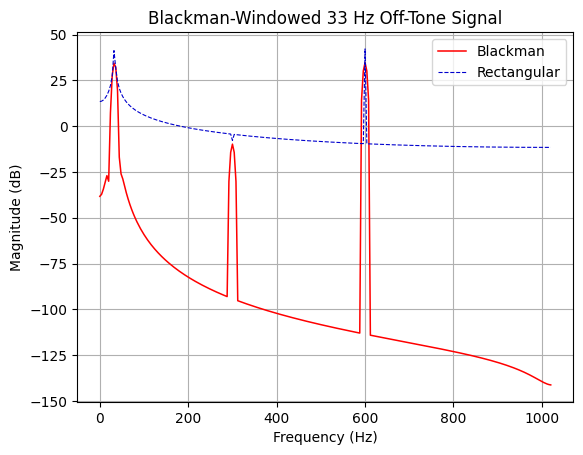

In [94]:
s7_blackman = s7*windows.blackman(len(s7))

fig4, ax4 = plotting.plot_spectrum((s7_blackman, fs, L, 'fft', None), (s7, fs, L, 'fft', None), title='Blackman-Windowed 33 Hz Off-Tone Signal', labels=['Blackman', 'Rectangular'],
                                   styles=[{'color': 'red', 'linewidth': '1.1'}, {'color': 'mediumblue', 'linewidth': '0.8', 'linestyle': 'dashed'}])

As expected, the off-tone spike sees appreciable thickening while retaining most of its energy all the way down to -60 dB. Naturally, the aligned 300 Hz tone is even more explicit under these conditions. Moreover, it is important to note that aligned tones, even those far away from off-bin tones, must suffer the same widening of their mainlobes under windowing, despite lacking inherent leakage.

The Blackman window has a coherent gain of ~ 0.42

### Kaiser-Bessel Window

The Kaiser window is rather interesting. It doesn't take the form of a simple cosine expansion. Instead, this window is an approximation of the discrete prolate spheroidal sequence or Slepian function, a very powerful window in its own right, as an expansion in terms of the Bessel functions. Namely,
$$
\begin{align}
w_{\text{Kaiser}}[n] =&\; \frac{I_0\left(\pi \alpha\sqrt{1-\left(\frac{2n}{N} - 1\right)^2}\right)}{I_0(\pi\alpha)},\quad 0 \leq n\leq N \nonumber \\
=&\; \frac{I_0\left(\pi \alpha\sqrt{1-\left(\frac{2n}{N}\right)^2}\right)}{I_0(\pi\alpha)},\quad -N/2 \leq n\leq N/2 \nonumber,
\end{align}
$$
where $I_0$ is the 0th-order modified Bessel function of the first kind. Its power series expansion is given by 
$$
I_0(x) = \sum_{i=0}^{\infty}\frac{1}{(i!)^2}\left(\frac{x}{2}\right)^{2i}.
$$
Additionally, $\alpha$ is the shape parameter that determines the tradeoff between mainlobe width and sidelobe attenuation. 

This kind of window is particularly useful because, given its basis on the Slepian function, it maximizes energy concentration in the main lobe. This makes it ideal for filter design.

Below is the implementation for generating this function.

In [95]:
def build_kaiser_bessel(vi, alpha, terms=30):
    """
    Compute the Kaiser-Bessel kernel values at normalized positions vi for shape parameter alpha.
    """
    vi = np.asarray(vi, float)
    d = alpha
    n = d * np.sqrt(1 - vi**2)

    accd = np.ones_like(n)
    accn = np.ones_like(n)
    fact = 1.0

    for i in range(1, terms):
        fact *= i
        coeff = 1.0 / (fact * fact)
        accd += (0.5 * d)**(2*i) * coeff
        accn += (0.5 * n)**(2*i) * coeff

    return accn / accd

The time-domain plot looks as follows.

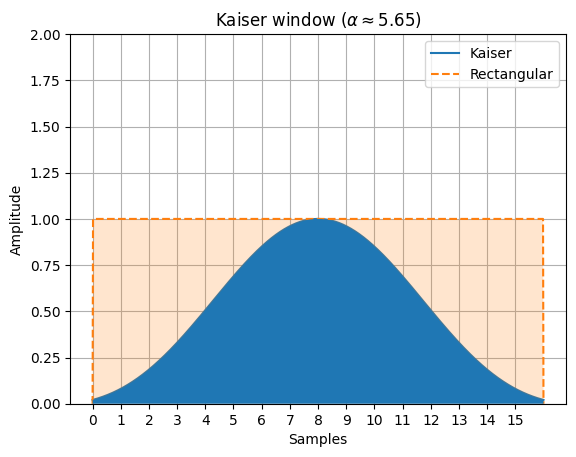

In [96]:
N = 16
n = np.linspace(0, N, 1000)
A_att = 60
alpha2 = 0.1102 * (A_att - 8.7)

vi = 2*n/(N) - 1
w_kaiser = build_kaiser_bessel(vi, alpha2)


plt.plot(n, w_kaiser, label='Kaiser')
plt.plot(n, w_rect, linestyle='dashed', label='Rectangular')
plt.title(r'Kaiser window ($\alpha \approx 5.65$)')
plt.xticks(np.arange(16))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.ylim(0, 2)

plt.fill_between(n, w_kaiser, zorder=3)
plt.fill_between(n, w_rect, zorder=2, alpha=0.2)
plt.grid(zorder=0)
plt.legend()
plt.show()

Again, we see the familiar tapered shape, however there are some subtle differences as compared with a cosine that manifest in the frequency plot.

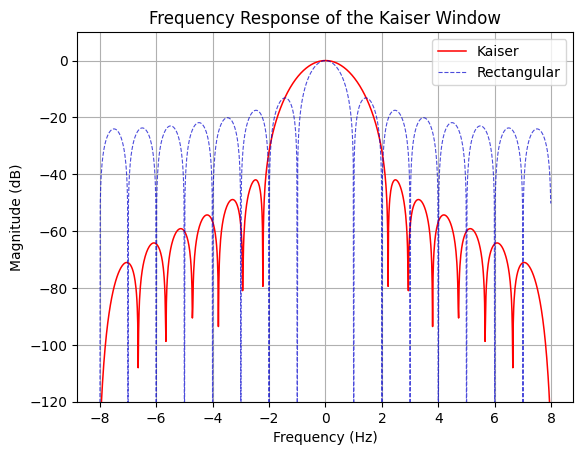

In [97]:
N = 16
ZP  = 64*N
n = np.arange(N)

vi = 2*n/(N - 1) - 1

# Kaiser fft
w_kaiser_discrete = build_kaiser_bessel(vi, alpha2)
w_kaiser_discrete = np.pad(w_kaiser_discrete, (0, ZP - N))

W_kaiser = transforms.radix2_fft(w_kaiser_discrete, ZP)
W_kaiser = np.abs(W_kaiser)
W_kaiser = transforms.fftshift(W_kaiser)
W_kaiser /= W_kaiser.max() if W_kaiser.max() > 0 else 1.0
W_kaiser = np.maximum(W_kaiser, 10**(-140/20))
W_kaiser = 20*np.log10(W_kaiser)

f = np.linspace(-8, 8, ZP, endpoint=False)

plt.plot(f, W_kaiser, color='r', linewidth='1.1', label='Kaiser')
plt.plot(f, W_rect, color='mediumblue', linestyle='dashed', linewidth='0.8', alpha=0.7, label='Rectangular')
plt.ylim(-120, 10)
plt.title('Frequency Response of the Kaiser Window')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.show()

Because of its tunability via $\alpha$, the kaiser window is not of fixed shape. In certain cases, the mainlobe can become very wide if the user is interested purely in sidelobe suppression. Whereas, in other cases, the intention may be to keep the mainlobe narrow, with only subtle attenuation. This can be very useful when attempting to suss out hidden tones, where deep attenuation may reveal the noise floor but the tone is nonetheless smothered by the thickening of the main spike. The Kaiser window can be manipulated in order to perfectly balance those two properties for a given situation.

One generalized feature of the Kaiser window is that the sidelobes demonstrate monotonic decay.  

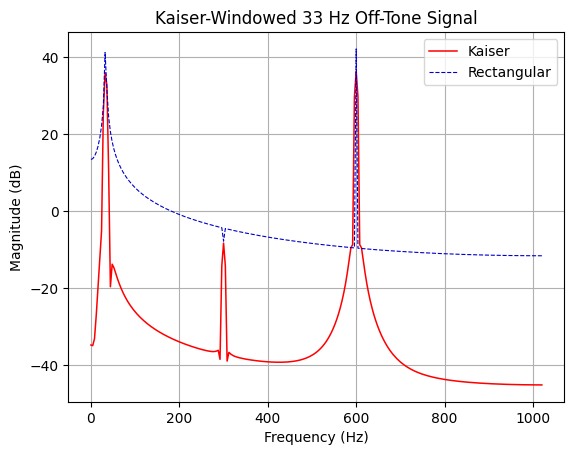

In [98]:
s7_kaiser = s7*windows.kaiser_window(len(s7), alpha)

fig5, ax5 = plotting.plot_spectrum((s7_kaiser, fs, L, 'fft', None), (s7, fs, L, 'fft', None), title='Kaiser-Windowed 33 Hz Off-Tone Signal', labels=['Kaiser', 'Rectangular'],
                                   styles=[{'color': 'red', 'linewidth': '1.1'}, {'color': 'mediumblue', 'linewidth': '0.8', 'linestyle': 'dashed'}])

Unsurprisingly, the frequency response of our off-tone signal through a Kaiser window sits somewhere between the Hamming and Blackman responses. Of course, depending on the chosen $\alpha$, this response will look different. Additionally, becuase of its variability, we can't guarantee that the lobe profile's zeros match up with the rectangular window's zeros. This means that an aligned tone like the 600 Hz one above can also suffer some widening.

# Key Takeaways

## Spectral leakage 

When a sampled signal is truncated in such a way as to render the resultant section of signal aperiodic, the Fourier transform's frequency basis bins become misaligned with respect to the signal's time-samples. As a result, any offset frequency components in the signal's spectral representation become smeared out with increasing proximity to the noise floor, leaking energy into nearby bins and obscuring weaker components. 

Abrupt truncation is equivalent to multiplying the "true" infinite signal by a unity step function or rectangular "window."

## Alternative Windowing to Manage Leakage

Instead of defaulting to a rectangular window, sampled time-data can be multiplied by a function that softens the discontinuity that develops if a misaligned signal were tiled. Such a window typically has a cosine-like construction, where most of the center data is preserved while the edge data is tapered off. A consequence of doing is that there must be a tradeoff between the width of the mainlobe, the one responsible for the frequency spike's natural width, and the attenuation of the sidelobes, the ones responsible for the depth at which bulging begins. Below are the some example windows used in this document's library, along with their characteristics.

$$
\small
\begin{array}{lcccc}
\hline
\textbf{Window} & \textbf{CG} & \textbf{ENBW (bins)} & \textbf{PSL (dB)} & \textbf{Mainlobe (bins)}\\
\hline
\text{Rectangular} & 1.000 & 1.00 & -13.26 & 2\\
\text{Hann} & 0.500 & 1.50 & \approx -31.5 & 4\\
\text{Hamming} & 0.538 & \approx 1.36 & \approx -42.7 & 4\\
\text{Blackman}(\alpha=0.16) & \approx 0.42 & \approx 1.73 & \approx -57 & 6\\
\text{Kaiser}(\beta \approx 5.65) & \approx 0.50 & \approx 2.0 & \approx -60 & \approx 5\text{--}6\\
\hline
\end{array}
$$


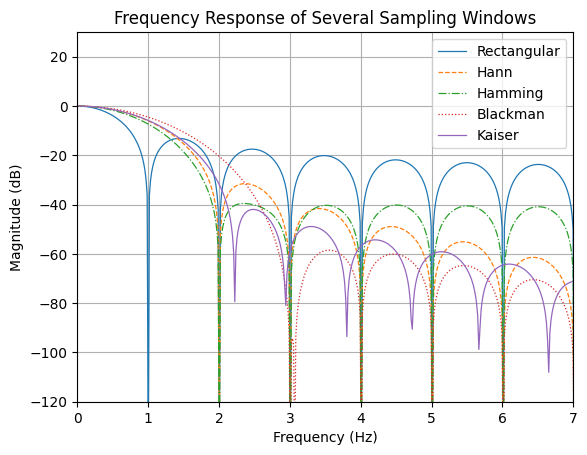

In [128]:
half = 512
freqs = np.linspace(0, N /2, half)
plt.plot(freqs, W_rect[half:], label='Rectangular', alpha=1, linewidth=0.9)
plt.plot(freqs, W_hann[half:], label='Hann', linestyle='--', linewidth=0.9)
plt.plot(freqs, W_hamming[half:], label='Hamming', linestyle='-.', linewidth=0.9)
plt.plot(freqs, W_blackman[half:], label='Blackman', linestyle=':', linewidth=0.9)
plt.plot(freqs, W_kaiser[half:], label='Kaiser', linewidth=0.9)
plt.grid()
plt.ylim(-120, 30)
plt.xlim(0, 7)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of Several Sampling Windows')
plt.legend()